### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imutils
import math
import cv2
import os

### Loading and Processing the Dataset

In [2]:
# Declare empty lists to hold the images and their respective labels
data = []
labels = []

In [3]:
# Construct a transform function to convert the image 2-d array to a tensor
convert_tensor = transforms.Compose([transforms.ToTensor()])

In [4]:
# Processing every image
for imagePath in sorted(list(paths.list_images("E:\CS projects\Smile Detection\SMILEsmileD-master\SMILEs"))):
    # Load the image, pre-process it, and store it in the data variabele created above
    image = cv2.imread(imagePath)                    # Load the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert image to grayscale
    image = imutils.resize(image, width=28)          # Resize image to a fixed size of 28x28 pixels
    image = convert_tensor(image)                    # Convert the image to a tensor                   
    data.append(image)                               # Append the processed image to the list
    
    #Extracting labels based on the folder the image is stored
    label = imagePath.split(os.path.sep)[-3]
    label = 1 if label == "positives" else 0
    labels.append(label)

In [5]:
(X_train, X_test, y_train, y_test) = train_test_split(data,labels, test_size=0.20, stratify=labels, random_state=42)

In [6]:
train_data = list(zip(X_train,y_train))
test_data = list(zip(X_test,y_test))

In [7]:
# Declaring data loaders to train and test data in small batches 
train_loader = data_utils.DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

### Accounting for Class Imbalance

In [8]:
class_counts = np.bincount(y_train)
num_classes = len(class_counts)
total_samples = len(y_train)

class_weights = []
for count in class_counts:
    weight = 1 / (count / total_samples)
    class_weights.append(weight)
    
class_weights = torch.FloatTensor(class_weights)
class_weights

tensor([1.3894, 3.5678])

### Forward Pass for one element
To determine no. of neurons at each layer by stepping through each layer

In [9]:
x= X_train[0].view(1,1,28,28)
x.shape

torch.Size([1, 1, 28, 28])

In [10]:
# Pass through 1st convolution layer
conv1 = nn.Conv2d(1, 6, 3, 1)
x = F.relu(conv1(x)) # Rectified Linear Unit for our activation function
x.shape

torch.Size([1, 6, 26, 26])

In [11]:
# Pass through the 1st pooling layer
x = F.max_pool2d(x,2,2) # kernel of 2x2 and stride of 2
x.shape

torch.Size([1, 6, 13, 13])

In [12]:
# Pass through 2nd convolution layer
conv2 = nn.Conv2d(6, 16, 3, 1)
x = F.relu(conv2(x)) # Rectified Linear Unit for our activation function
x.shape

torch.Size([1, 16, 11, 11])

In [13]:
# Pass through the 2nd pooling layer
x = F.max_pool2d(x,2,2) # kernel of 2x2 and stride of 2
x.shape

torch.Size([1, 16, 5, 5])

### CNN Model Definition Definition

In [14]:
# CNN Model Class
class ConvolutionalNetwork(nn.Module):
    
    #Defining the layers of the CNN
    def __init__(self):
        super().__init__()
        
        #Convolution Layers
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    # Forward pass
    def forward(self, X):
        
        # 1st Pass of convolution
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2) # 2x2 kernel and stride 2

        # 2nd Pass of convolution
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2) # 2x2 kernel and stride 2

        # Re-View to flatten it out the 2-d array to a linear input
        X = X.view(-1, 16*5*5) 

        # Fully Connected Layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)

In [15]:
# Create an Instance of the Model
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [16]:
# Loss Function Optimizer with calculated weights
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training the Model

In [17]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 15
train_losses = []
test_losses = []
train_correct = []
test_correct = []
num_total_train = []
num_total_test = []

# For Loop of each Epoch
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    num_train = 0
    num_test = 0


    # Train
    for b,(X_train, y_train) in enumerate(train_loader):
        b+=1 # start our batches at 1
        y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
        loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in y_train

        predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
        batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
        trn_corr += batch_corr # keep track as we go along in training.
        num_train += len(y_train)

        # Update our parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # Print out some results
        if b%200 == 0:
            print(f'Epoch: {i}  Batch: {b}  Loss: {round(loss.item(),4)}')

    train_losses.append(loss)
    train_correct.append(trn_corr)
    num_total_train.append(num_train)


    # Testing with no gradient so it doesn't update the weights and biases with test data
    with torch.no_grad(): 
        for b,(X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1] # Getting index of the max neuron as the predicted class
            tst_corr += (predicted == y_test).sum() # Counting the correct predictions
            num_test += len(y_test)                 # Counting the total test data

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    num_total_test.append(num_test)
    

current_time = time.time()
total = current_time - start_time
print(f'Training Time: {round(total/60,2)} minutes!')

Epoch: 0  Batch: 200  Loss: 0.6589
Epoch: 0  Batch: 400  Loss: 0.4053
Epoch: 0  Batch: 600  Loss: 0.1901
Epoch: 0  Batch: 800  Loss: 0.3474
Epoch: 0  Batch: 1000  Loss: 0.2369
Epoch: 1  Batch: 200  Loss: 0.582
Epoch: 1  Batch: 400  Loss: 0.5335
Epoch: 1  Batch: 600  Loss: 0.7973
Epoch: 1  Batch: 800  Loss: 0.4235
Epoch: 1  Batch: 1000  Loss: 0.5558
Epoch: 2  Batch: 200  Loss: 0.1621
Epoch: 2  Batch: 400  Loss: 1.529
Epoch: 2  Batch: 600  Loss: 0.3904
Epoch: 2  Batch: 800  Loss: 0.2055
Epoch: 2  Batch: 1000  Loss: 0.0623
Epoch: 3  Batch: 200  Loss: 0.2383
Epoch: 3  Batch: 400  Loss: 0.3219
Epoch: 3  Batch: 600  Loss: 0.1353
Epoch: 3  Batch: 800  Loss: 0.3725
Epoch: 3  Batch: 1000  Loss: 0.2121
Epoch: 4  Batch: 200  Loss: 0.4631
Epoch: 4  Batch: 400  Loss: 0.1383
Epoch: 4  Batch: 600  Loss: 0.0923
Epoch: 4  Batch: 800  Loss: 0.302
Epoch: 4  Batch: 1000  Loss: 0.2002
Epoch: 5  Batch: 200  Loss: 0.3518
Epoch: 5  Batch: 400  Loss: 0.0436
Epoch: 5  Batch: 600  Loss: 0.0944
Epoch: 5  Batch: 8

### Visualizing Train-Test Loss & Accuracy

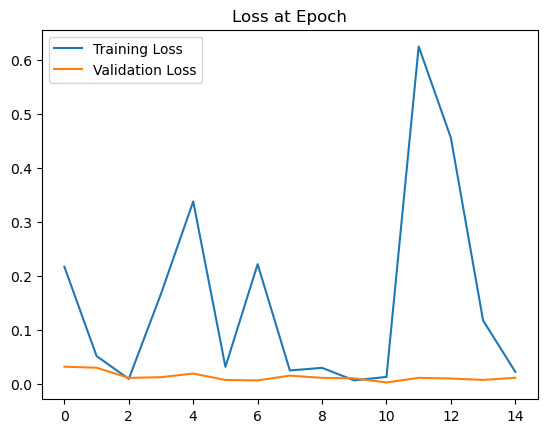

In [18]:
# Graph the loss at epoch
plt.plot([train_losses[i].item() for i in range(len(train_losses))], label="Training Loss")
plt.plot([test_losses[i].item() for i in range(len(test_losses))], label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

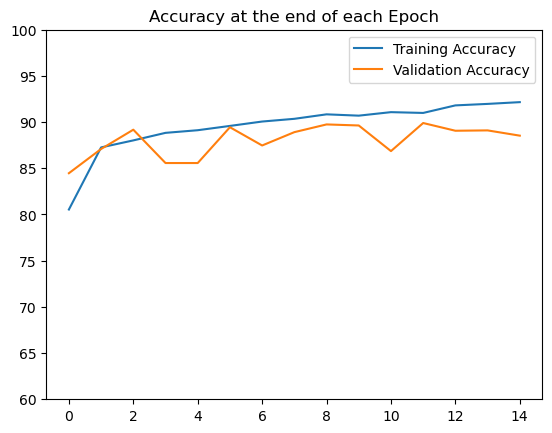

In [19]:
# graph the accuracy at the end of each epoch
plt.plot([(t/n)*100 for t,n in zip(train_correct, num_total_train)], label="Training Accuracy")
plt.plot([(t/n)*100 for t,n in zip(test_correct, num_total_test)], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.ylim(60,100)
plt.legend()

### Prediction for the entire Test Set

In [20]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [21]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [22]:
print(classification_report(y_test.numpy(),(torch.max(y_val,1)).indices.numpy()))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1895
           1       0.75      0.88      0.81       738

    accuracy                           0.89      2633
   macro avg       0.85      0.88      0.86      2633
weighted avg       0.89      0.89      0.89      2633



### Saving and Loading the trained model
Change the save path as required and update the load path to the downloaded .pt file

In [23]:
torch.save(model.state_dict(), "E:\CS projects\Smile Detection\model_2.pt")

In [24]:
model_test = ConvolutionalNetwork()
model_test.load_state_dict(torch.load("E:\CS projects\Smile Detection\model_1.pt"))
model_test.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

### FINAL PREDICTION
Load the final test images in a single folder and update the path below

In [25]:
# Pre-processing
final_test_data = []
for imagePath in sorted(list(paths.list_images("E:\CS projects\Smile Detection\Test_Final"))):
    image = cv2.imread(imagePath)                    # Load the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert image to grayscale
    image = imutils.resize(image, width=28)          # Resize image to a fixed size of 28x28 pixels
    image = convert_tensor(image)                    # Convert the image to a tensor
    final_test_data.append(image)                    # Append the processed image to the list

In [26]:
# Loading the entire test set
final_test_load_all = DataLoader(final_test_data, batch_size=10000, shuffle=False)

In [27]:
# Forward Pass / Predictions
with torch.no_grad():
    for X_test in final_test_load_all:
        final_y_val = model_test(X_test)
        final_predicted = torch.max(final_y_val, 1)[1]
final_labels = []
for prediction in final_predicted:
    label = "Smiling" if prediction==1 else "not smiling :("
    final_labels.append(label)

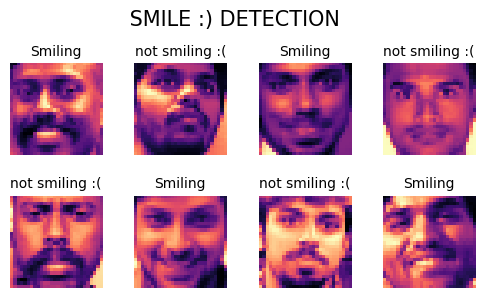

In [28]:
#Visualizing the predicitons
X_grid = 4
Y_grid = math.ceil(len(final_test_data)/X_grid)

fig,axes=plt.subplots(Y_grid, X_grid,figsize = (6,3))
axes = axes.ravel()
plt.subplots_adjust(wspace=.35, hspace=.35)
fig.suptitle(' SMILE :) DETECTION ', fontsize=15, y = 1.05)

#Plot each prediction
for i in np.arange(0, X_grid * Y_grid ):
    axes[i].imshow(final_test_data[i].reshape(-1,28), cmap='magma')
    axes[i].set_title(final_labels[i],fontsize = 10)
    axes[i].axis('off')